### Installing Packages and importing libraries

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from transformers import EarlyStoppingCallback, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
import matplotlib.pyplot as plt
import seaborn as sns

### Load and prepare the dataset

In [ ]:
#LOAD dataset
train_df = pd.read_csv('train_dataset_AD.csv')
val_df = pd.read_csv('validation_dataset_AD.csv')
test_df = pd.read_csv('test_dataset_AD.csv')
selected_columns = ['label_M', 'IPD Description']
train_df = train_df[selected_columns]
val_df = val_df[selected_columns]
test_df = test_df[selected_columns]

In [ ]:
print("Training dataset size: ",train_df.shape)
print("Validation dataset size: ",val_df.shape)
print("Test dataset size: ",test_df.shape)

Training dataset size:  (3500, 2)
Validation dataset size:  (750, 2)
Test dataset size:  (750, 2)


In [ ]:
# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Tokenizer
checkpoint = "cambridgeltl/BioRedditBERT-uncased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)
# Initialize model
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)


In [ ]:
# Tokenize the datasets
def tokenize_data(example):
    max_length = 512
    return tokenizer(example['IPD Description'], padding='max_length', truncation=True)


In [ ]:
train_dataset = train_dataset.map(tokenize_data, batched=True)
val_dataset = val_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

In [ ]:
#remove the text column and rename the label column
train_dataset = train_dataset.remove_columns(["IPD Description"])
val_dataset = val_dataset.remove_columns(["IPD Description"])
test_dataset = test_dataset.remove_columns(["IPD Description"])
train_dataset = train_dataset.rename_column("label_M", "labels")
val_dataset = val_dataset.rename_column("label_M", "labels")
test_dataset = test_dataset.rename_column("label_M", "labels")
test_dataset.set_format("torch")
train_dataset.set_format("torch")
val_dataset.set_format("torch")

In [ ]:
val_dataset.column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


### Training the model

In [ ]:
# Function to compute metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    warmup_steps=20,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)


In [ ]:
# optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    val_dataset, batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dataset, batch_size=8, collate_fn=data_collator
)

In [ ]:

num_training_steps = len(train_dataloader) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=training_args.warmup_steps,
                                            num_training_steps=num_training_steps)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
# Train the model
trainer.train()

### Model Evaluation

In [ ]:
# Evaluation
trainer.evaluate(test_dataset)

{'eval_loss': 0.426917165517807,
 'eval_accuracy': 0.8306666666666667,
 'eval_f1': 0.8315885641651154,
 'eval_precision': 0.8333732614014564,
 'eval_recall': 0.8306666666666667,
 'eval_runtime': 4.7873,
 'eval_samples_per_second': 156.665,
 'eval_steps_per_second': 19.635,
 'epoch': 5.0}

In [ ]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)


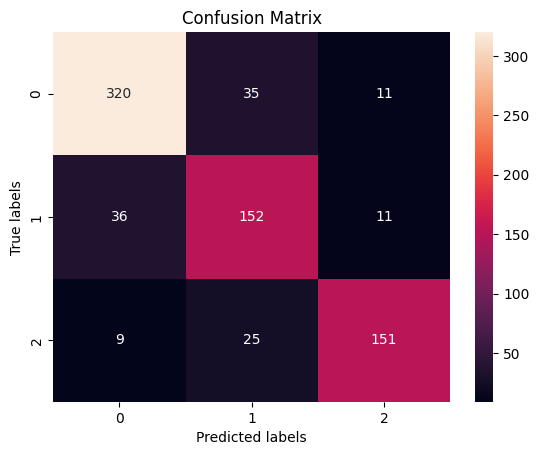

In [ ]:
predictions = trainer.predict(test_dataset)
# Get the predicted labels
pred_labels = np.argmax(predictions.predictions, axis=1)
# Get the true labels
true_labels = predictions.label_ids
# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
# Plotting confusion matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

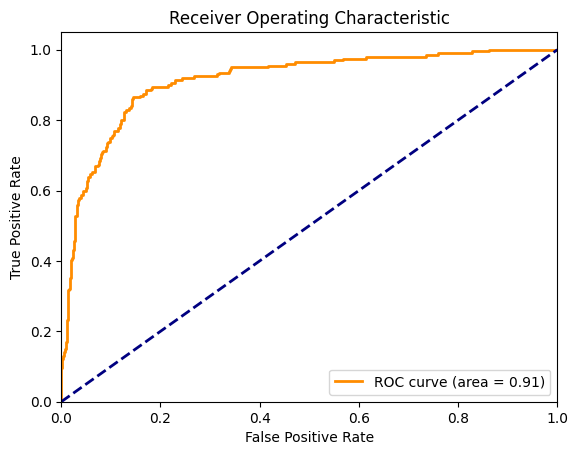

In [ ]:
pred_probs = predictions.predictions
true_labels = predictions.label_ids
# Compute ROC curve and AUC for each class
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# table of metrics
metrics = trainer.evaluate(test_dataset)
metrics_table = pd.DataFrame([metrics], columns=metrics.keys())


In [ ]:
metrics_table

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.426917,0.830667,0.831589,0.833373,0.830667,5.0194,149.42,18.727,5.0
